# Relacions dels atrubuts amb el target (winner)

**Nota:** Moltes de les funcions que s'utilitzen es podran trobar en el document **Atributs_amb_target.py**, tot això per millorar la visualització del NoteBook i poder fer ús d'elles en altres documents.


In [43]:
# Importar llibreries necessàries
import pandas as pd
import numpy as np

from Dades_Individuals import *
from Atributs_amb_target import *

In [44]:
DataSet = pd.read_csv("../LOL - Dataset/games.csv")
DataSet_champions = pd.read_json("../LOL - Dataset/champion_info.json")

In [45]:
# Primer mirem quines són totalment identiques
duplicated_rows = DataSet[DataSet.duplicated(keep=False)]
num_duplicated_rows = len(duplicated_rows)

# Si n'hi ha, les eliminem
DataSet_cleaned = DataSet.drop_duplicates()

## GameID

Per la meva part no crec que el **GameID** pugui tenir alguna relació, però per si de cas analitzarem el cas on hi ha algun periode seguit de victories d'algun equip

ANÀLISI DE PARTIDES CONSECUTIVES GUANYADES PER EL MATEIX EQUIP

Total de seqüències de victòries: 25579
Longitud mitjana de seqüència: 2.00
Longitud màxima de seqüència: 17
Longitud mínima de seqüència: 1
Mediana de seqüència: 2.00

DISTRIBUCIÓ DE SEQÜÈNCIES POR LONGITUD
 Partides_Consecutives  Nombre_Seqüencies
                     1              12757
                     2               6467
                     3               3172
                     4               1619
                     5                813
                     6                376
                     7                178
                     8                102
                     9                 42
                    10                 28
                    11                  7
                    12                  5
                    13                  1
                    14                  6
                    15                  2
                    16                  3
              

C:\Users\laiao\AppData\Local\Temp\ipykernel_24696\997106010.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6+' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  visualitzacio_df_grouped.loc[visualitzacio_df_grouped['Partides_Consecutives'] > 5, 'Partides_Consecutives'] = '6+'


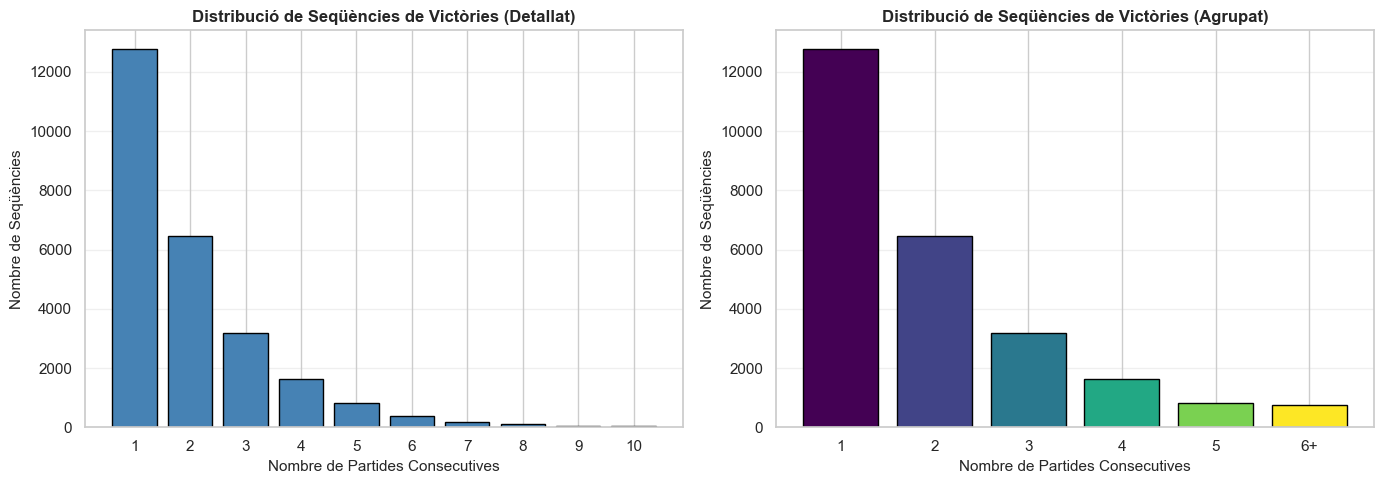


ESTADÍSTIQUES ADDICIONALS
Seqüències de 1 partida(s) consecutiva(s): 12757 (49.87%)
Seqüències de 2 partida(s) consecutiva(s): 6467 (25.28%)
Seqüències de 3 partida(s) consecutiva(s): 3172 (12.40%)
Seqüències de 4 partida(s) consecutiva(s): 1619 (6.33%)
Seqüències de 5 partida(s) consecutiva(s): 813 (3.18%)
Seqüències de més de 5 partides: 751 (2.94%)


In [46]:
# Ordenar per gameId per assegurar consecutivitat
df_sorted = DataSet_cleaned.sort_values('gameId').reset_index(drop=True)

# Identificar les seqüències de victòries consecutives del mateix equip
consecutive_wins = []
current_winner = None
current_streak = 0

for _, row in df_sorted.iterrows():
    winner = row['winner']
    
    if winner == current_winner:
        # Continuem la seqüència del mateix guanyador
        current_streak += 1
    else:
        # Canvi de guanyador
        if current_streak > 0:
            consecutive_wins.append(current_streak)
        current_winner = winner
        current_streak = 1

# Afegir l'última seqüència si existeix
if current_streak > 0:
    consecutive_wins.append(current_streak)

print("="*80)
print("ANÀLISI DE PARTIDES CONSECUTIVES GUANYADES PER EL MATEIX EQUIP")
print("="*80)

print(f"\nTotal de seqüències de victòries: {len(consecutive_wins)}")
print(f"Longitud mitjana de seqüència: {np.mean(consecutive_wins):.2f}")
print(f"Longitud màxima de seqüència: {max(consecutive_wins)}")
print(f"Longitud mínima de seqüència: {min(consecutive_wins)}")
print(f"Mediana de seqüència: {np.median(consecutive_wins):.2f}")

# Crear DataFrame amb els resultats per a visualització
streak_series = pd.Series(consecutive_wins)
streak_counts = streak_series.value_counts().sort_index()

# Crear DataFrame ordenat per visualització
visualitzacio_df = pd.DataFrame({
    'Partides_Consecutives': streak_counts.index,
    'Nombre_Seqüencies': streak_counts.values
}).reset_index(drop=True)

print("\n" + "="*80)
print("DISTRIBUCIÓ DE SEQÜÈNCIES POR LONGITUD")
print("="*80)
print(visualitzacio_df.to_string(index=False))

# Agrupar les seqüències llargues (> 5) per millor visualització
visualitzacio_df_grouped = visualitzacio_df.copy()
visualitzacio_df_grouped.loc[visualitzacio_df_grouped['Partides_Consecutives'] > 5, 'Partides_Consecutives'] = '6+'

# Reagrupar si s'ha modificat
if (visualitzacio_df_grouped['Partides_Consecutives'] == '6+').any():
    visualitzacio_df_grouped = visualitzacio_df_grouped.groupby('Partides_Consecutives')['Nombre_Seqüencies'].sum().reset_index()
    # Ordenar: números primers, depois '6+'
    numeric_rows = visualitzacio_df_grouped[visualitzacio_df_grouped['Partides_Consecutives'] != '6+'].sort_values('Partides_Consecutives')
    rest = visualitzacio_df_grouped[visualitzacio_df_grouped['Partides_Consecutives'] == '6+']
    visualitzacio_df_grouped = pd.concat([numeric_rows, rest], ignore_index=True)

print("\n" + "="*80)
print("DISTRIBUCIÓ AGRUPADA (per a gràfic)")
print("="*80)
print(visualitzacio_df_grouped.to_string(index=False))

# Gràfic de barres
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gràfic 1: Distribució detallada (primeres 10 seqüències)
ax1.bar(visualitzacio_df.head(10)['Partides_Consecutives'].astype(str), 
        visualitzacio_df.head(10)['Nombre_Seqüencies'], 
        color='steelblue', edgecolor='black')
ax1.set_xlabel('Nombre de Partides Consecutives', fontsize=11)
ax1.set_ylabel('Nombre de Seqüències', fontsize=11)
ax1.set_title('Distribució de Seqüències de Victòries (Detallat)', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Gràfic 2: Distribució agrupada (per visualització més clara)
colors = plt.cm.viridis(np.linspace(0, 1, len(visualitzacio_df_grouped)))
ax2.bar(visualitzacio_df_grouped['Partides_Consecutives'].astype(str), 
        visualitzacio_df_grouped['Nombre_Seqüencies'], 
        color=colors, edgecolor='black')
ax2.set_xlabel('Nombre de Partides Consecutives', fontsize=11)
ax2.set_ylabel('Nombre de Seqüències', fontsize=11)
ax2.set_title('Distribució de Seqüències de Victòries (Agrupat)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Estadístiques addicionals
print("\n" + "="*80)
print("ESTADÍSTIQUES ADDICIONALS")
print("="*80)

for i in range(1, min(6, max(consecutive_wins) + 1)):
    count = sum(1 for s in consecutive_wins if s == i)
    pct = (count / len(consecutive_wins)) * 100
    print(f"Seqüències de {i} partida(s) consecutiva(s): {count} ({pct:.2f}%)")

long_streaks = sum(1 for s in consecutive_wins if s > 5)
pct_long = (long_streaks / len(consecutive_wins)) * 100
print(f"Seqüències de més de 5 partides: {long_streaks} ({pct_long:.2f}%)")

Com podem observar la majoria de partides, sempre s'han jugat alternant el guanyador.
La majoria de seqüències són molt curtes, 1 o 2 partides, això ens indivia que els equiops tendeixen a alternar victories. Les seqüències llarges (>5) són estranyes, les quals representen menys del 3% de les partides. I la seqüència més llarga amb la que ens trobem és de 17 partides consecutives.


## CreationTime

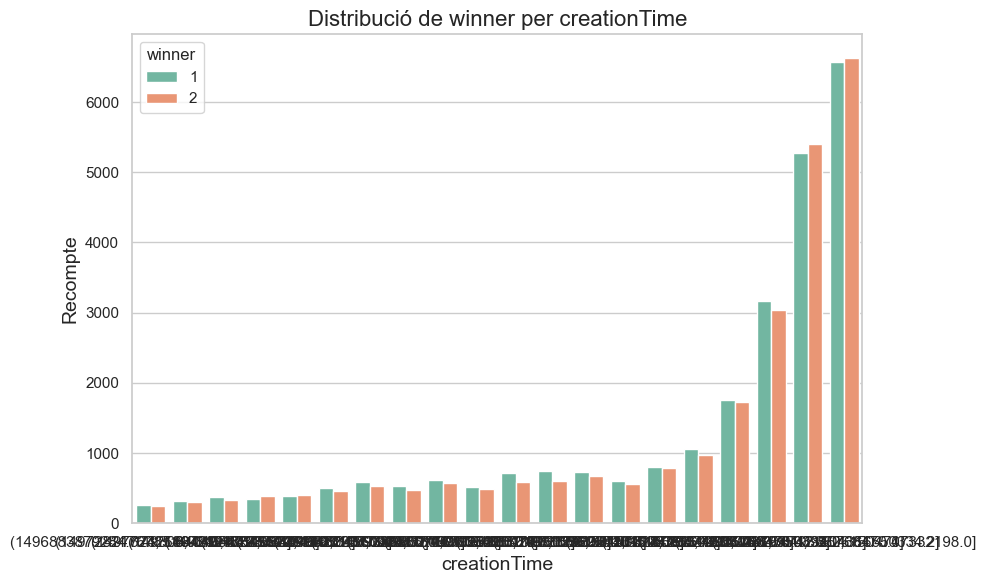

In [47]:
crear_distribucio_target(DataSet_cleaned, 'creationTime', target='winner', bins=20)

- Les partides es concentren significativament en els períodes més recents 
- Aquesta concentració suggereix que les dades provenen d'un período específic de competició, possiblement una temporada de campionat
- La majoria de partides (~40,000 de 51,000) ocorren en els últims bins temporals

## gameDuration

Com hem vist en l'apartat individual de l'anàlisi d'aquests atribut, hi ha dades amb el mateix **gameDuration** i els percentatges de cadascun dels equips que han gunyat. En aquest cas, mirem la seva distribució per poder visualitzar millor les dades.

Si tenim en compte de cada valor únic de la columna **gameDuration** no podem vuere correctament la distribució, així que la millor manera és juntar-los en conjunts de 400 segons cadascun


RESULTATS AGRUPATS PER INTERVALS DE 400 SEGONS
Interval de duracions analitzat: 190 - 3977 segons
Nombre total d'intervals: 10
Nombre total de partides en intervals: 50740

DETALL PER CADA INTERVAL DE 400 SEGONS:

Interval: 0-399 segons - Total partides: 1182
  Equip 1: 610 victòries (51.6%)
    GameIDs: [3330152268, 3246799766, 3284885837, 3303374774, 3266491878]...
  Equip 2: 572 victòries (48.4%)
    GameIDs: [3258796399, 3324626165, 3317340805, 3262708423, 3325085865]...
  → L'equip 1 domina (+38 partides)

Interval: 1200-1599 segons - Total partides: 11776
  Equip 1: 6180 victòries (52.5%)
    GameIDs: [3327363504, 3329224025, 3308987932, 3328984872, 3287517913]...
  Equip 2: 5596 victòries (47.5%)
    GameIDs: [3318040883, 3325996400, 3318940474, 3289287394, 3329435919]...
  → L'equip 1 domina (+584 partides)

Interval: 1600-1999 segons - Total partides: 17526
  Equip 1: 8795 victòries (50.2%)
    GameIDs: [3326086514, 3229566029, 3326856598, 3314215542, 3284613292]...
  Equip 2

C:\Users\laiao\AppData\Local\Temp\ipykernel_24696\3391304018.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicate_durations['duration_interval'] = pd.cut(duplicate_durations['gameDuration'],


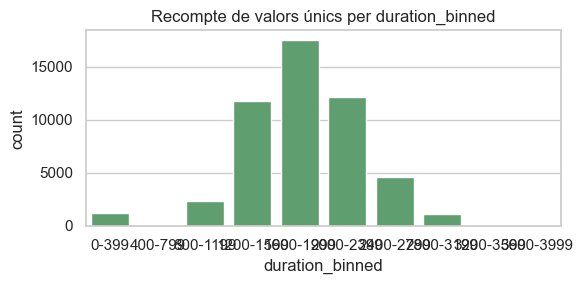

In [48]:
duplicate_durations = DataSet_cleaned[DataSet_cleaned.duplicated(subset=['gameDuration'], keep=False)]

# Crear intervals de 400 segons
min_duration = duplicate_durations['gameDuration'].min()
max_duration = duplicate_durations['gameDuration'].max()

# Crear bins de 400 segons
bins = list(range(int(min_duration // 400) * 400, 
                 int((max_duration // 400) + 1) * 400 + 1, 400))

# Etiquetes per als intervals
bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]

# Afegir columna d'interval al DataFrame
duplicate_durations['duration_interval'] = pd.cut(duplicate_durations['gameDuration'], 
                                                 bins=bins, 
                                                 labels=bin_labels, 
                                                 include_lowest=True)

# Crear llista per emmagatzemar resultats agrupats
interval_results_list = []

# Analitzar cada interval de 400 segons
for interval in bin_labels:
    interval_data = duplicate_durations[duplicate_durations['duration_interval'] == interval]
    
    if not interval_data.empty:
        total_games = len(interval_data)
        team1_data = interval_data[interval_data['winner'] == 1]
        team2_data = interval_data[interval_data['winner'] == 2]
        
        team1_wins = len(team1_data)
        team2_wins = len(team2_data)
        
        # Obtenir les llistes de gameID per a cada equip
        team1_game_ids = team1_data['gameId'].tolist()
        team2_game_ids = team2_data['gameId'].tolist()
        
        # Calcular percentatges
        team1_pct = (team1_wins / total_games) * 100
        team2_pct = (team2_wins / total_games) * 100
        
        # Determinar l'equip dominant
        dominant_team = 1 if team1_wins > team2_wins else 2 if team2_wins > team1_wins else 0
        win_difference = abs(team1_wins - team2_wins)
        
        interval_results_list.append({
            'duration_interval': interval,
            'total_games': total_games,
            'team1_wins': team1_wins,
            'team2_wins': team2_wins,
            'team1_win_pct': team1_pct,
            'team2_win_pct': team2_pct,
            'dominant_team': dominant_team,
            'win_difference': win_difference,
            'team1_game_ids': team1_game_ids,
            'team2_game_ids': team2_game_ids
        })

# Crear DataFrame amb els resultats agrupats
interval_results_df = pd.DataFrame(interval_results_list)

# Ordenar per interval
interval_results_df = interval_results_df.sort_values('duration_interval').reset_index(drop=True)

# Mostrar resultats
print("\n" + "="*80)
print("RESULTATS AGRUPATS PER INTERVALS DE 400 SEGONS")
print("="*80)
print(f"Interval de duracions analitzat: {min_duration} - {max_duration} segons")
print(f"Nombre total d'intervals: {len(interval_results_df)}")
print(f"Nombre total de partides en intervals: {interval_results_df['total_games'].sum()}")


# Mostrar resum per cada interval
print("\n" + "="*80)
print("DETALL PER CADA INTERVAL DE 400 SEGONS:")
print("="*80)

for _, row in interval_results_df.iterrows():
    print(f"\nInterval: {row['duration_interval']} segons - Total partides: {row['total_games']}")
    print(f"  Equip 1: {row['team1_wins']} victòries ({row['team1_win_pct']:.1f}%)")
    print(f"    GameIDs: {row['team1_game_ids'][:5]}{'...' if len(row['team1_game_ids']) > 5 else ''}")
    print(f"  Equip 2: {row['team2_wins']} victòries ({row['team2_win_pct']:.1f}%)")
    print(f"    GameIDs: {row['team2_game_ids'][:5]}{'...' if len(row['team2_game_ids']) > 5 else ''}")
    
    if row['dominant_team'] == 0:
        print("  → Empate perfecte")
    else:
        print(f"  → L'equip {row['dominant_team']} domina (+{row['win_difference']} partides)")

# ANALITZAR TENDÈNCIES GENERALS
print("\n" + "="*80)
print("ANÀLISI DE TENDÈNCIES:")
print("="*80)

# Intervals on un equip guanya clarament (diferència > 2 partides o > 60%)
clear_wins_df = interval_results_df[interval_results_df['win_difference'] > 2]
if not clear_wins_df.empty:
    team1_clear_wins = len(clear_wins_df[clear_wins_df['dominant_team'] == 1])
    team2_clear_wins = len(clear_wins_df[clear_wins_df['dominant_team'] == 2])
    
    print(f"Intervals amb victòria clara (>2 partides de diferència): {len(clear_wins_df)}")
    print(f"  - Equip 1 domina clarament en: {team1_clear_wins} intervals")
    print(f"  - Equip 2 domina clarament en: {team2_clear_wins} intervals")

# Mostrar intervals amb més partides
print(f"\nIntervals amb més partides duplicades:")
top_intervals = interval_results_df.nlargest(5, 'total_games')
for _, row in top_intervals.iterrows():
    print(f"  {row['duration_interval']} segons: {row['total_games']} partides")

# UTILITZAR LA FUNCIÓ analyze_numeric_column AMB ELS INTERVALS
print("\n" + "="*80)
print("ANÀLISI GRÀFIC AMB LA FUNCIÓ analyze_numeric_column")
print("="*80)

# Crear una versió amb intervals per a l'anàlisi gràfica
analysis_df = duplicate_durations.copy()
analysis_df['duration_binned'] = pd.cut(analysis_df['gameDuration'], 
                                      bins=bins, 
                                      labels=bin_labels, 
                                      include_lowest=True)

# Analitzar amb la funció
analyze_numeric_column(
    df=analysis_df, 
    col='duration_binned', 
    target='winner', 
    show_plots=True, 
    bins=None,
    plot_types=['count']
)

Com podem veure en els resultats de l'anàlisi, acabem amb 10 intervals de 400 segons cadascun:

**- Interval: 0-399 segons - Total partides: 1182**
Podem veure que hi ha una majora de partides guanyades per part de *l'equip 1*, però només per 38 partides. **NO** és una majoria suficient per poder determinar, només correspon a un 0.3% de les partides en aquest conjunt.

**- Interval: 1200-1599 segons - Total partides: 11776**
Aquest interval podem veure més majoria de partides, l'interval amb més majoria, **584**, guanyant *l'equip 1* com en la majoria internvals. 


En els intervals (**2800-3199 segons, 3200-3599 segons, 400-799 segons i 800-1199 segons**) l'equip guanyador ha sigut *1* tenint en compte els comentats anteriorment comentats.

*L'equip 2* guanya **3 dels 10** intervals (**2000-2399 segons, 2400-2799 segons, 3600-3999 segons**)


Una cosa que podem fer és mirar els diferents jugadors o conjunts de jugadors en cadascun dels conjunts d'intervals, haver si hi ha alguna correlació. **Combinacions herois i encanteris.ipynb**


## First

En la gràfica que ens dona el percentatge o el *count* de les vegades que un dels equips ha obtingut el primer **first** en relació si han gunyat la partida el mateix equip.

### FirstBlood

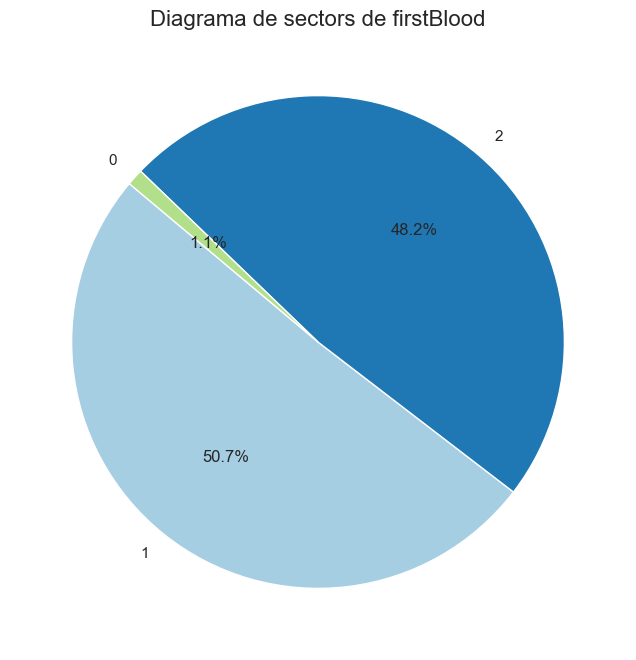

In [49]:
crear_diagrama_de_sectors(DataSet_cleaned, 'firstBlood', target='winner')

Observem que en la majoria de casos, un dels dos equips se'm porta el primer **kill** de la partida. *Només un 1.1%* de les dades ens trobem amb un empat, cosa bastant rara en aquest tipus de jocs, principalment, creureia que és una errada o pot haver la possibilitat tendint al ~0%, on simultaniament ha hagut un *kill* per part dels dos equips.


ANÀLISI: FIRST Blood
Mostrant: PERCENTATGES de victòries quan es té el 'first'

Equip 1:
  Total vegades que ha aconseguit el 'first': 25880
  Vegades que va GUANYAR tenint el 'first': 15405 (59.52%)
  Vegades que va PERDER tenint el 'first': 10475 (40.48%)
  ✓ Avantatge SIGNIFICATIU: +9.52%

Equip 2:
  Total vegades que ha aconseguit el 'first': 24619
  Vegades que va GUANYAR tenint el 'first': 14465 (58.76%)
  Vegades que va PERDER tenint el 'first': 10154 (41.24%)
  ✓ Avantatge SIGNIFICATIU: +8.76%

--------------------------------------------------------------------------------
ESTADÍSTIQUES GLOBALS:
--------------------------------------------------------------------------------
Total d'ocasions on algun equip va aconseguir el 'first': 50499
Total de victòries quan es tenia el 'first': 29870
Taxa de victòria global si es té el 'first': 59.15%
Predictibilitat (avantatge mig): 9.14%

--------------------------------------------------------------------------------
CLASSIFICACIÓ:
---

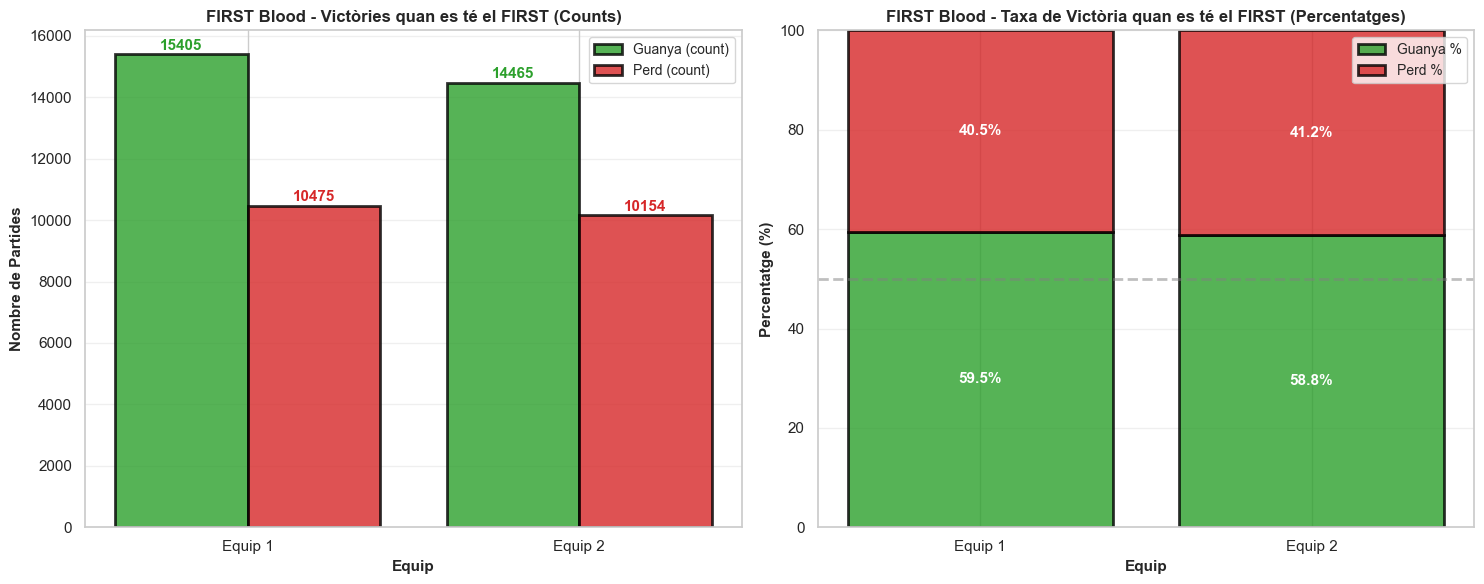

In [50]:
result_firstBlood = analitzar_first_event(DataSet_cleaned, 'firstBlood', target='winner')

En el **fistBlood** hi ha certa relació, ja que obtenir el primer **kill** i a la vegada gunyar la partida, pels dos equips, ens donen resultats bastant semblants.

Obtenim un **9,1**4% de probabilitat que hi hagi relació entre **firstBlood i winner**.

### firstTower

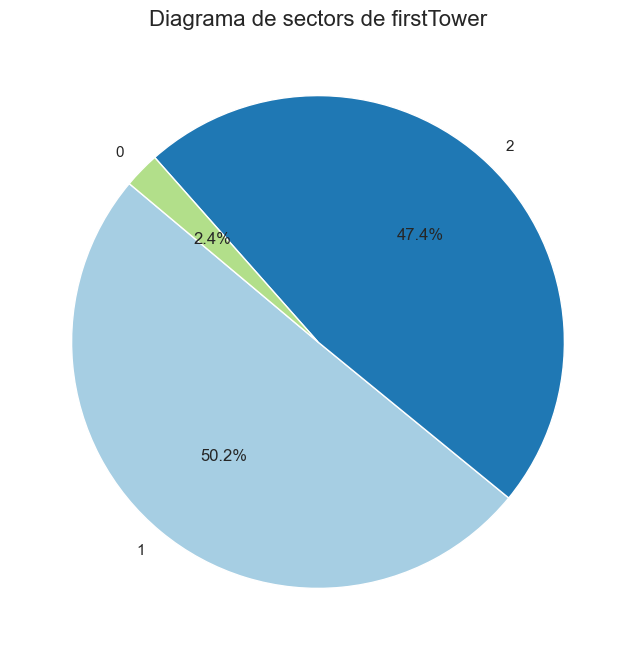

In [51]:
crear_diagrama_de_sectors(DataSet_cleaned, 'firstTower', target='winner')

Obtenim percentatges bastant semblants que amb el **firstBlood** per part dels dos equips, només amb petites diferències de percentatge.


ANÀLISI: FIRST Tower
Mostrant: PERCENTATGES de victòries quan es té el 'first'

Equip 1:
  Total vegades que ha aconseguit el 'first': 25630
  Vegades que va GUANYAR tenint el 'first': 18167 (70.88%)
  Vegades que va PERDER tenint el 'first': 7463 (29.12%)
  ✓ Avantatge SIGNIFICATIU: +20.88%

Equip 2:
  Total vegades que ha aconseguit el 'first': 24218
  Vegades que va GUANYAR tenint el 'first': 17153 (70.83%)
  Vegades que va PERDER tenint el 'first': 7065 (29.17%)
  ✓ Avantatge SIGNIFICATIU: +20.83%

--------------------------------------------------------------------------------
ESTADÍSTIQUES GLOBALS:
--------------------------------------------------------------------------------
Total d'ocasions on algun equip va aconseguir el 'first': 49848
Total de victòries quan es tenia el 'first': 35320
Taxa de victòria global si es té el 'first': 70.86%
Predictibilitat (avantatge mig): 20.85%

--------------------------------------------------------------------------------
CLASSIFICACIÓ:
--

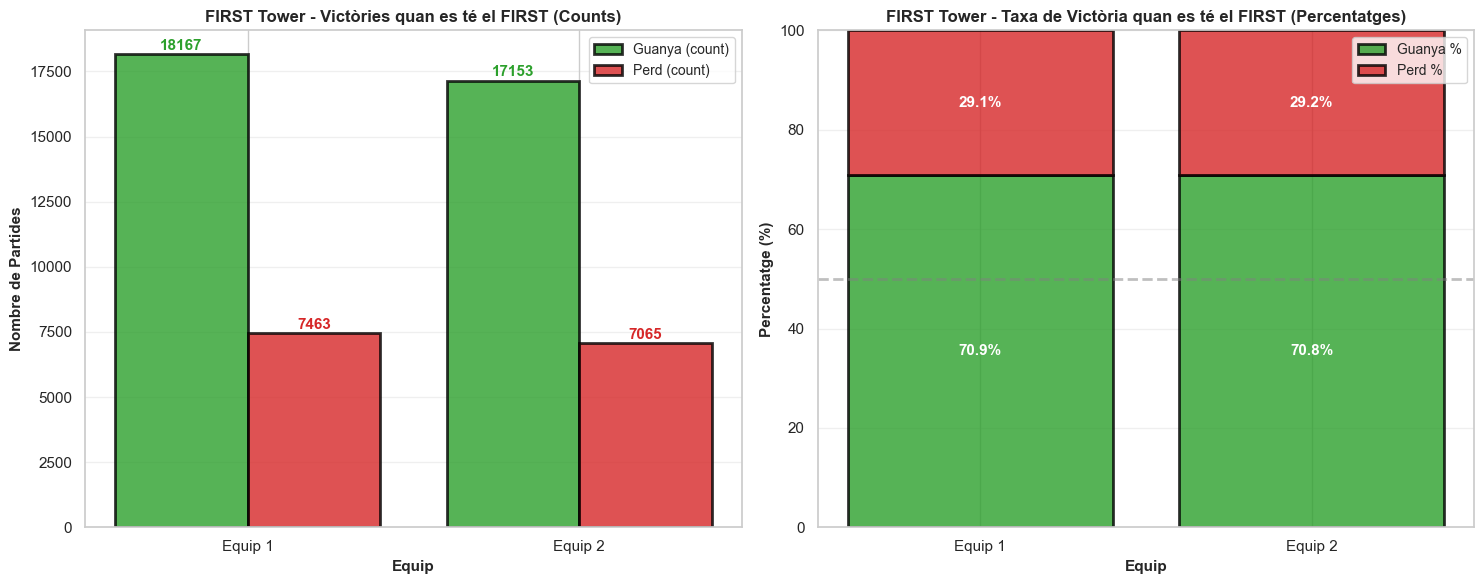

In [52]:
result_firstTower = analitzar_first_event(DataSet_cleaned, 'firstTower', target='winner')

Només mirant la primera gràfica, podem determiar que l'equip que se'n porta **firstTower** influencia bastant amb el resultat de la partida. 

En els dos casos, el +70% de les vegades que un dels equips aconseguiex **firstTower** acaba gunyant la partida, un percentatge molt alt. Amb un resultat d'influència del **20.85%**.

### firstInhibitor

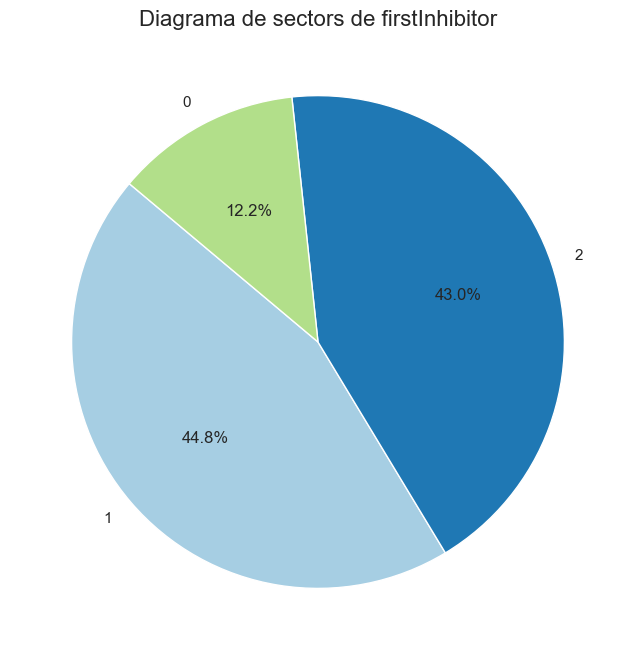

In [53]:
crear_diagrama_de_sectors(DataSet_cleaned, 'firstInhibitor', target='winner')

Ha diferència dels altre dos casos, si que el percentatge de "cap equip" obté el primer inhibidor és bastant alt.


ANÀLISI: FIRST Inhibitor
Mostrant: PERCENTATGES de victòries quan es té el 'first'

Equip 1:
  Total vegades que ha aconseguit el 'first': 22851
  Vegades que va GUANYAR tenint el 'first': 20770 (90.89%)
  Vegades que va PERDER tenint el 'first': 2081 (9.11%)
  ✓ Avantatge SIGNIFICATIU: +40.89%

Equip 2:
  Total vegades que ha aconseguit el 'first': 21976
  Vegades que va GUANYAR tenint el 'first': 20073 (91.34%)
  Vegades que va PERDER tenint el 'first': 1903 (8.66%)
  ✓ Avantatge SIGNIFICATIU: +41.34%

--------------------------------------------------------------------------------
ESTADÍSTIQUES GLOBALS:
--------------------------------------------------------------------------------
Total d'ocasions on algun equip va aconseguir el 'first': 44827
Total de victòries quan es tenia el 'first': 40843
Taxa de victòria global si es té el 'first': 91.11%
Predictibilitat (avantatge mig): 41.12%

--------------------------------------------------------------------------------
CLASSIFICACIÓ:


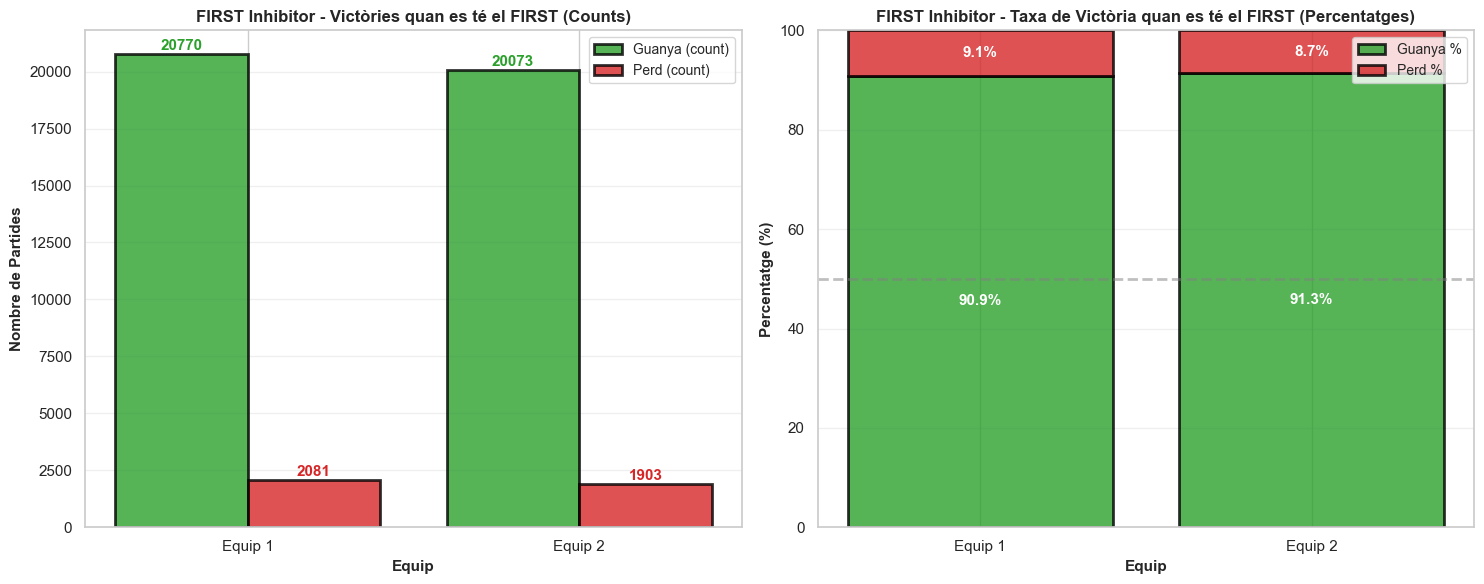

In [54]:
result_firstInhibitor = analitzar_first_event(DataSet_cleaned, 'firstInhibitor', target='winner')

A diferènica del percentatge de partides on l'inhibidor no és per cap dels dos equips, obtenir-lo si que marca una gran diferència en la victoria.

A si observem el mapa de les diferents estructures en el joc, l'inhibidor es troba, per no dir, és l'última estructura ha passar abans que l'equip contrari pugui guanyar la partida.

L'interpretació de les dades són bastant esperades, ja que l'equip que *"guanya"* aquesta estructura, està a uns minuts a gunyar.

Obtenim un **41.12%** de percentatge d'influència que un equip dels dos guanyi.

### firstBaron

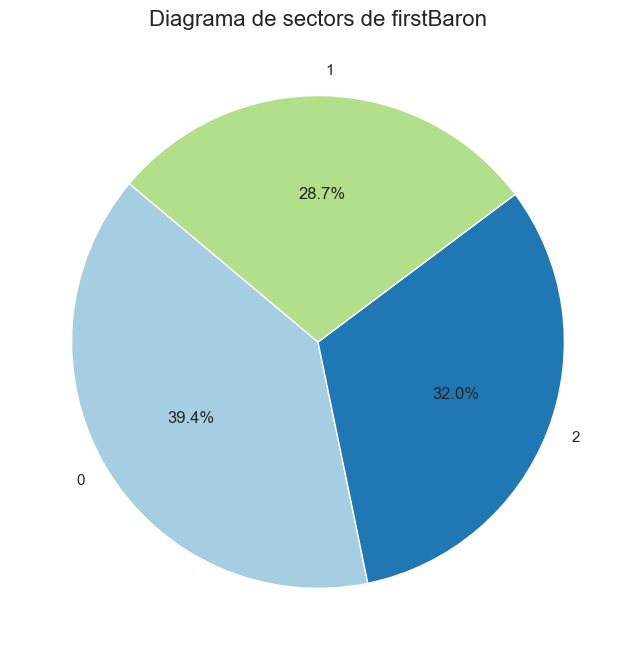

In [55]:
crear_diagrama_de_sectors(DataSet_cleaned, 'firstBaron', target='winner')


ANÀLISI: FIRST Baron
Mostrant: PERCENTATGES de victòries quan es té el 'first'

Equip 1:
  Total vegades que ha aconseguit el 'first': 14631
  Vegades que va GUANYAR tenint el 'first': 11878 (81.18%)
  Vegades que va PERDER tenint el 'first': 2753 (18.82%)
  ✓ Avantatge SIGNIFICATIU: +31.18%

Equip 2:
  Total vegades que ha aconseguit el 'first': 16331
  Vegades que va GUANYAR tenint el 'first': 13100 (80.22%)
  Vegades que va PERDER tenint el 'first': 3231 (19.78%)
  ✓ Avantatge SIGNIFICATIU: +30.22%

--------------------------------------------------------------------------------
ESTADÍSTIQUES GLOBALS:
--------------------------------------------------------------------------------
Total d'ocasions on algun equip va aconseguir el 'first': 30962
Total de victòries quan es tenia el 'first': 24978
Taxa de victòria global si es té el 'first': 80.67%
Predictibilitat (avantatge mig): 30.70%

--------------------------------------------------------------------------------
CLASSIFICACIÓ:
--

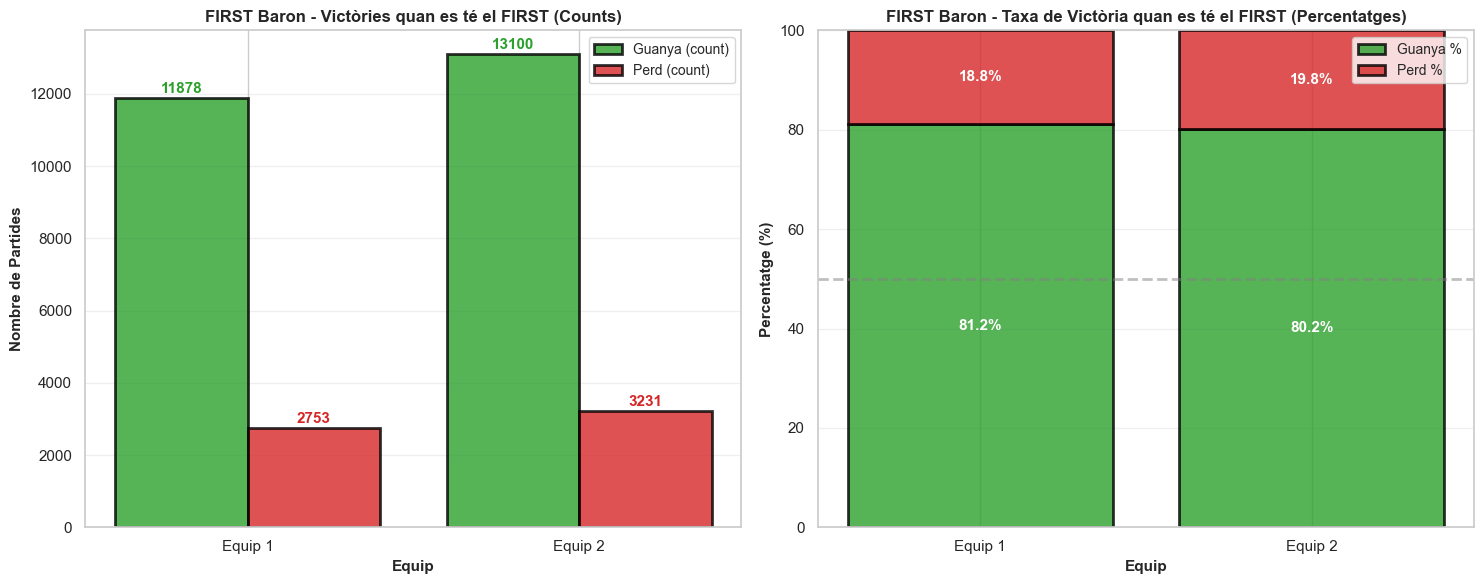

In [56]:
result_firstBaron = analitzar_first_event(DataSet_cleaned, 'firstBaron', target='winner')

Un altre atribut amb una gran correlació amb el *target* amb un **30-70%**.

El Baron és una criatoria que apareix a mitjan partida, que aporta una millora de percentatges a tot l'equip que l'aconsegueix matar. Aquesta pujada d'estadistiques tenen una gran repercusió.

### firstDragon

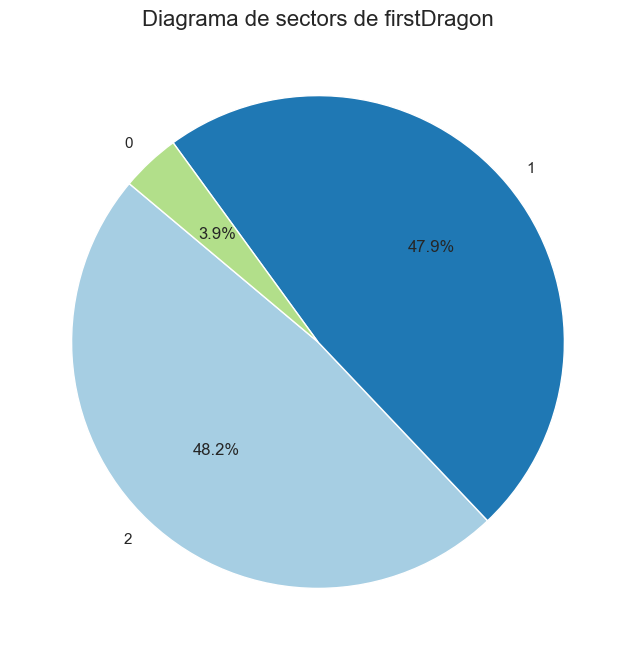

In [57]:
crear_diagrama_de_sectors(DataSet_cleaned, 'firstDragon', target='winner')


ANÀLISI: FIRST Dragon
Mostrant: PERCENTATGES de victòries quan es té el 'first'

Equip 1:
  Total vegades que ha aconseguit el 'first': 24466
  Vegades que va GUANYAR tenint el 'first': 16785 (68.61%)
  Vegades que va PERDER tenint el 'first': 7681 (31.39%)
  ✓ Avantatge SIGNIFICATIU: +18.61%

Equip 2:
  Total vegades que ha aconseguit el 'first': 24605
  Vegades que va GUANYAR tenint el 'first': 16595 (67.45%)
  Vegades que va PERDER tenint el 'first': 8010 (32.55%)
  ✓ Avantatge SIGNIFICATIU: +17.45%

--------------------------------------------------------------------------------
ESTADÍSTIQUES GLOBALS:
--------------------------------------------------------------------------------
Total d'ocasions on algun equip va aconseguir el 'first': 49071
Total de victòries quan es tenia el 'first': 33380
Taxa de victòria global si es té el 'first': 68.02%
Predictibilitat (avantatge mig): 18.03%

--------------------------------------------------------------------------------
CLASSIFICACIÓ:
-

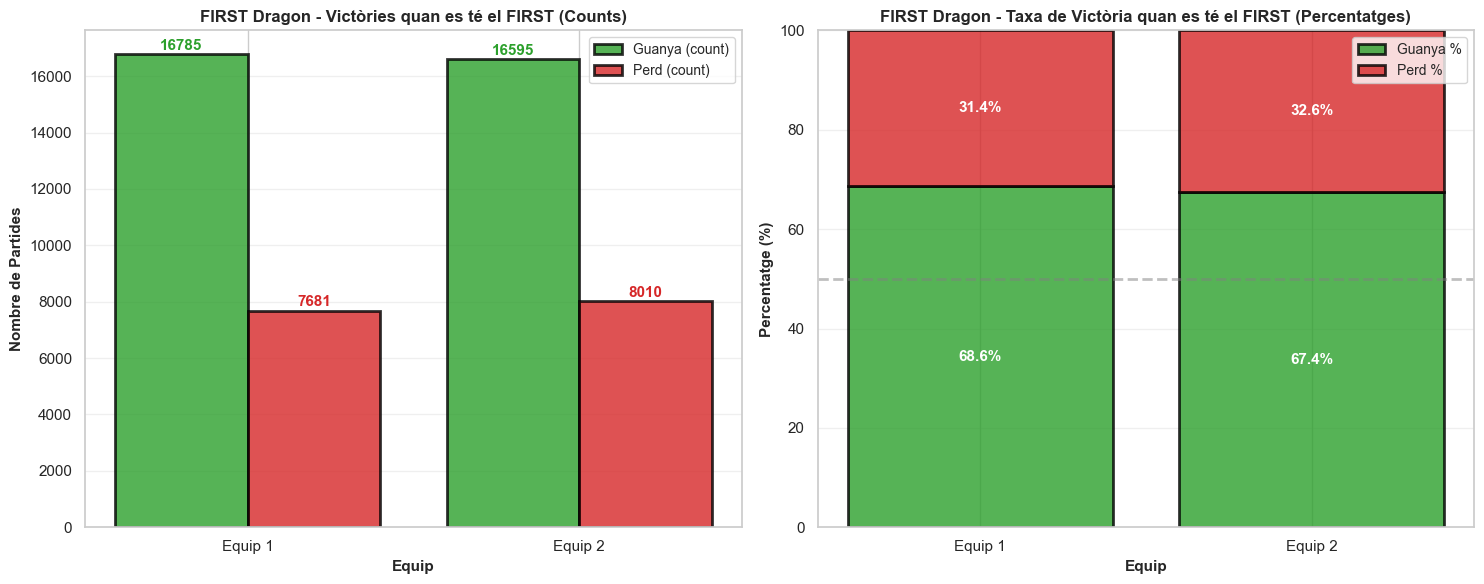

In [58]:
result_firstDragon = analitzar_first_event(DataSet_cleaned, 'firstDragon', target='winner')

El **Dragon** també és una criatura que dona una millora en les estadísitques, encara que pel que veig o no dona un *plus* tant gran o, a lo millor, apareix tant al començament de la partida com en el final que no és tant influent.

### firstRiftHerald

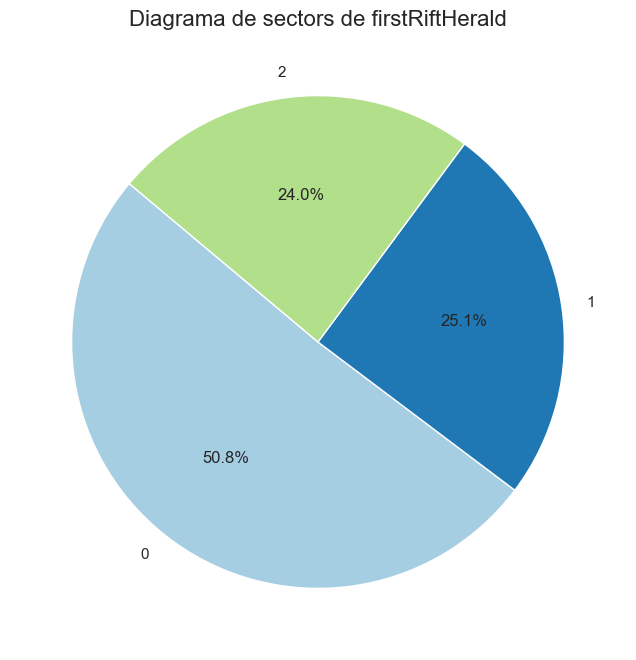

In [59]:
crear_diagrama_de_sectors(DataSet_cleaned, 'firstRiftHerald', target='winner')


ANÀLISI: FIRST RiftHerald
Mostrant: PERCENTATGES de victòries quan es té el 'first'

Equip 1:
  Total vegades que ha aconseguit el 'first': 12833
  Vegades que va GUANYAR tenint el 'first': 8914 (69.46%)
  Vegades que va PERDER tenint el 'first': 3919 (30.54%)
  ✓ Avantatge SIGNIFICATIU: +19.46%

Equip 2:
  Total vegades que ha aconseguit el 'first': 12265
  Vegades que va GUANYAR tenint el 'first': 8519 (69.46%)
  Vegades que va PERDER tenint el 'first': 3746 (30.54%)
  ✓ Avantatge SIGNIFICATIU: +19.46%

--------------------------------------------------------------------------------
ESTADÍSTIQUES GLOBALS:
--------------------------------------------------------------------------------
Total d'ocasions on algun equip va aconseguir el 'first': 25098
Total de victòries quan es tenia el 'first': 17433
Taxa de victòria global si es té el 'first': 69.46%
Predictibilitat (avantatge mig): 19.46%

--------------------------------------------------------------------------------
CLASSIFICACIÓ:

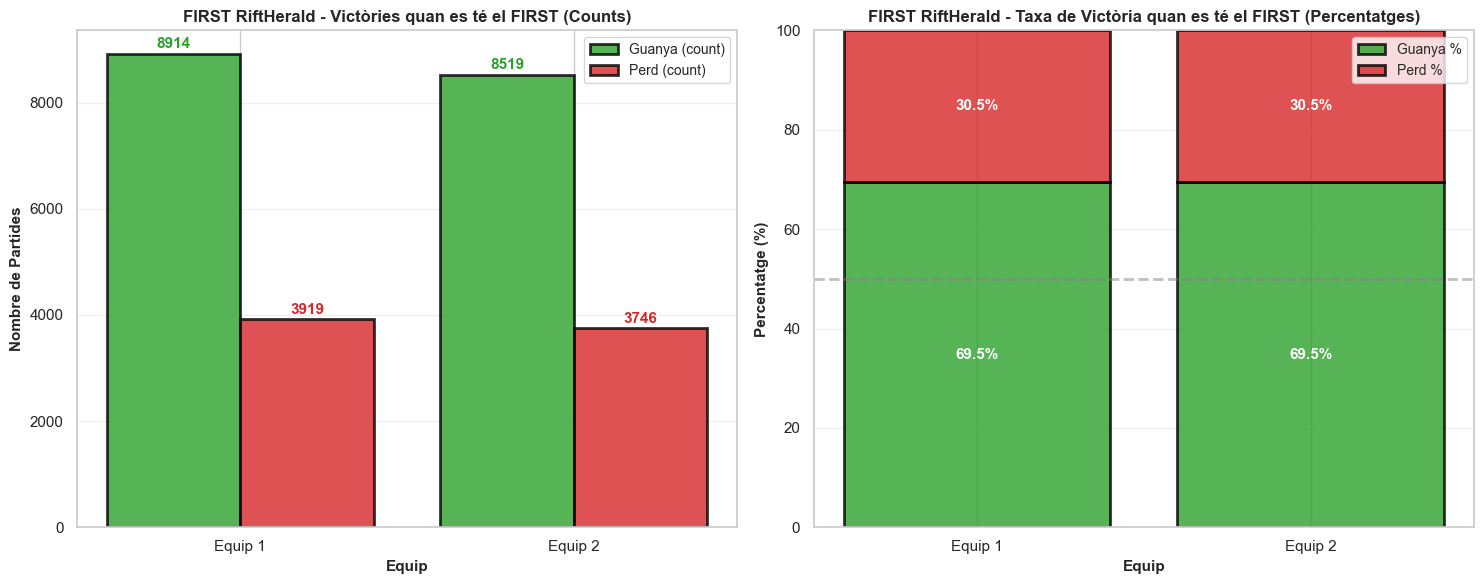

In [60]:
result_firstRiftHerald = analitzar_first_event(DataSet_cleaned, 'firstRiftHerald', target='winner')

## Percentatges d'influencia (%):
- firstBlood: 9.14
- firstTower: 20.85
- firstInhibitor: 41.12
- firstBaron: 30.70
- firstDragon: 18.03
- firstRiftHerald: 19.46

fins aquí l'anàlisi de les columnes amb el target, totes les altres és podran veure en **Combinacions herois i encanteris.ipynb**, ja que tenen relació amb combinacions d'herois, etc.